# Logistic regression Assumptions

- log-odds linearity
- multicollinearity
- outliers


## Data Loading


In [189]:
import pandas as pd
import matplotlib.pyplot as plt

from python_proj.utils.util import safe_save_fig, Counter
import python_proj.utils.exp_utils as exp_utils

file_name = "dataset_transformed"
base_path = exp_utils.BASE_PATH
data_path = f"{base_path}/final_data/{file_name}.csv"
experiment_name = "ftc_collaborative_logit_model"
figure_base_path = f"{base_path}/figures/modelling/{file_name}/{experiment_name}"

# Meta stuff.
pr_merged_key = "PullRequestIsMerged"
ftc_key = "SubmitterIsFirstTimeContributor"
seed_counter = Counter()


# Loads dataframe.
df: pd.DataFrame = pd.read_csv(filepath_or_buffer=data_path, header=0)

# Loads first-time contributor data frame.
print(f"{len(df)=}")
print(f"{len(df.columns)=}")

# Creates sub-datasets.
metadata_fields = ["ID", "Project Name", "Submitter ID", "PR Number", "Closed At"]
dependent_fields = [pr_merged_key]
independent_fields = [
    field
    for field in df.columns
    if (field not in metadata_fields and field not in dependent_fields)
]

df.describe()

len(df)=1216221
len(df.columns)=47


,ID,Submitter ID,PR Number,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),...,ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + WeightedEcosystemSecondOrderInDegreeCentrality),ln(1 + WeightedEcosystemSecondOrderOutDegreeCentrality),ln(1 + WeightedIntraProjectSecondOrderInDegreeCentrality),ln(1 + WeightedIntraProjectSecondOrderOutDegreeCentrality),ln(1 + EcosystemIntegratorToSubmitterLinkIntensity),ln(1 + EcosystemSubmitterToIntegratorLinkIntensity),ln(1 + IntraProjectIntegratorToSubmitterLinkIntensity),ln(1 + IntraProjectSubmitterToIntegratorLinkIntensity)
count,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,...,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06
mean,1.473092e+08,5.092504e+06,8.089130e+02,5.029367e-01,4.028501e-01,9.853429e-02,3.751776e-01,5.922709e-02,4.195426e-01,1.183858e-01,...,9.542167e-03,1.752697e-02,5.187147e-02,4.183969e-02,4.879307e-02,4.224746e-02,1.636391e-02,1.873960e-02,3.015777e-02,4.075340e-02
std,9.954409e+07,7.968202e+06,2.304617e+03,4.710606e-01,4.523397e-01,2.907111e-01,4.479337e-01,2.285036e-01,2.256901e-01,7.147764e-02,...,5.263118e-02,8.245257e-02,8.805299e-02,8.227950e-02,9.041389e-02,8.358805e-02,7.454282e-02,8.090779e-02,8.503362e-02,9.483697e-02
min,6.870000e+02,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.924867e+07,4.674710e+05,5.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.365158e-01,7.525668e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.366714e+08,1.633887e+06,1.990000e+02,6.800000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.433349e-01,7.525668e-02,...,0.000000e+00,0.000000e+00,4.497554e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.260994e+08,6.254382e+06,6.840000e+02,1.000000e+00,9.391304e-01,0.000000e+00,9.230769e-01,0.000000e+00,5.863557e-01,1.505134e-01,...,0.000000e+00,0.000000e+00,7.187211e-02,4.786833e-02,5.941411e-02,4.589478e-02,0.000000e+00,0.000000e+00,0.000000e+00,1.070596e-02
max,3.617756e+08,5.973444e+07,8.297600e+04,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


## FTC Data Selection

Sumbsamples the dataframe to only contains FTC data, and drops all columns that become obsolete in that scenario.

In [190]:
# Drops non-FTC data.

df = df[df[ftc_key] == True]
print(f"{len(df)=}")

len(df)=426832


In [191]:
# Drops irrelevant columns.

not_applicable_fields = [
    ftc_key,
    "IntraProjectSubmitterPullRequestSuccessRate",
    "ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)",
]

df = df.drop(not_applicable_fields, axis=1)

independent_fields = [
    field for field in independent_fields if field not in not_applicable_fields
]

## Feature selection for collaborative model

Identifies all features that are not part of the collaborative model and drops those.

In [192]:
# Identifies the to-be-dropped features

from python_proj.utils.util import get_matching

has_eco_but_no_collab_pattern = (
    r"^(?!.*(?:LinkIntensity|DegreeCentrality))(?=.*Ecosystem).*"
)
dropped_fields = list(get_matching(independent_fields, has_eco_but_no_collab_pattern))

print(f"{len(dropped_fields)=}")
print(f"{dropped_fields=}")

len(dropped_fields)=20
dropped_fields=['EcosystemExperienceSubmitterPullRequestSuccessRate', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterIssueComme

In [193]:
# Drops the selected features

df = df.drop(dropped_fields, axis=1)
independent_fields = [
    field for field in independent_fields if field not in dropped_fields
]

print(f"{len(df.columns)=}")
df.describe()

len(df.columns)=24


,ID,Submitter ID,PR Number,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator),ln(1 + IntraProjectSubmitterPullRequestCommentCount),ln(1 + IntraProjectSubmitterIssueSubmissionCount),ln(1 + IntraProjectSubmitterIssueCommentCount),ln(1 + WeightedEcosystemSecondOrderInDegreeCentrality),ln(1 + WeightedEcosystemSecondOrderOutDegreeCentrality),ln(1 + WeightedIntraProjectSecondOrderInDegreeCentrality),ln(1 + WeightedIntraProjectSecondOrderOutDegreeCentrality),ln(1 + EcosystemIntegratorToSubmitterLinkIntensity),ln(1 + EcosystemSubmitterToIntegratorLinkIntensity),ln(1 + IntraProjectIntegratorToSubmitterLinkIntensity),ln(1 + IntraProjectSubmitterToIntegratorLinkIntensity)
count,4.268320e+05,4.268320e+05,426832.000000,426832.000000,426832.000000,426832.000000,426832.000000,426832.000000,426832.000000,426832.000000,426832.000000,426832.000000,426832.000000,426832.000000,426832.000000,426832.000000,426832.000000
mean,1.213651e+08,5.131872e+06,584.979807,0.491480,0.106394,0.198759,0.006047,0.011799,0.016845,0.040247,0.030729,0.006037,0.005398,0.009439,0.010828,0.004342,0.003974
std,9.542933e+07,8.008834e+06,1733.884021,0.223246,0.060923,0.165177,0.034110,0.038817,0.055581,0.079376,0.071545,0.031037,0.029246,0.055338,0.057704,0.022918,0.018988
min,1.153000e+03,1.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.799896e+07,4.987750e+05,30.000000,0.334352,0.075257,0.082940,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.011235e+08,1.681449e+06,122.000000,0.502926,0.075257,0.165879,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.888974e+08,6.317507e+06,469.000000,0.662211,0.119279,0.306913,0.000000,0.000000,0.000000,0.046312,0.023275,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.617756e+08,5.973444e+07,82976.000000,1.000000,1.000000,0.988390,0.764149,0.829546,0.907261,1.000000,1.000000,0.866813,0.815163,0.947803,0.952660,0.635732,0.577153


## Log-odds linearity


### Visual checking


untransformed


ln(1 + ControlPullRequestLifeTimeInMinutes):
0.00    0.001063
0.25    0.334385
0.50    0.502938
0.75    0.662219
1.00    1.000000
Name: ln(1 + ControlPullRequestLifeTimeInMinutes), dtype: float64

x=[0.20313003985756273, 0.4297486977295805, 0.5797929027759507, 0.7609818309565708], y=[0.9057591858220134, 1.2719326523803485, 0.9061575003566413, -0.2958488661040859]
ln(1 + ControlNumberOfCommitsInPullRequest):
0.00    0.075257
0.25    0.075257
0.50    0.075257
0.75    0.119279
1.00    1.000000
Name: ln(1 + ControlNumberOfCommitsInPullRequest), dtype: float64

x=[0.0752566818678054, 0.0752566818678054, 0.0752566818678054, 0.1505133637356109], y=[0.6989592177238404, 0.6989592177238404, 0.693238476770564, 0.5839928321999465]
ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator):
0.00    0.083914
0.25    0.133000
0.50    0.235576
0.75    0.349914
1.00    1.000000
Name: ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator), dtype: float64

x=[0.08391374337459265, 0.16782748674918

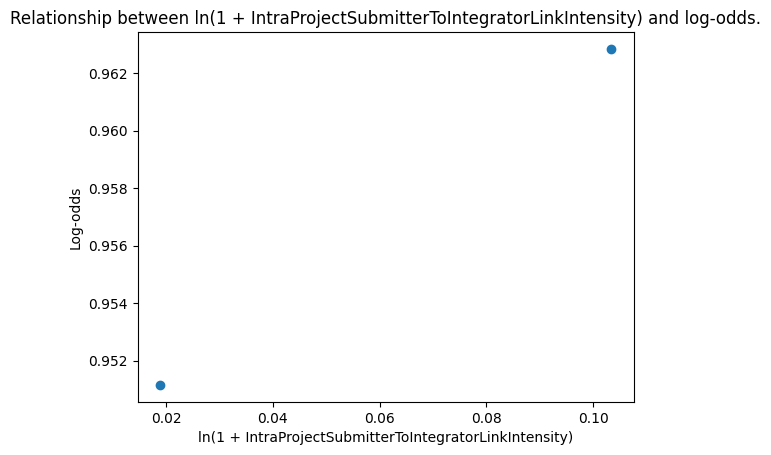

In [194]:
import regex as re
from numbers import Number
from typing import Callable, Iterator
import numpy as np
from python_proj.utils.util import tuple_chain


def test_log_linearity(
    independents: pd.DataFrame, dependent: pd.Series, transform_title: str = ""
):
    continuous_fields = independents.select_dtypes(include="number")

    all_data = pd.DataFrame()
    all_data[continuous_fields.columns] = continuous_fields.copy()
    all_data[pr_merged_key] = dependent.copy()

    for field in continuous_fields.columns:
        # Creates copy of the relevant fields.
        included = pd.DataFrame()
        included[field] = all_data[field].copy()
        included[pr_merged_key] = all_data[pr_merged_key].copy()

        # Removes data that will signifcantly skew the results.
        if re.match(r".*SuccessRate.*", field):
            # TODO: Figure out what to do with success rate.
            # We can't properly test the log-linearity with the current data.
            # count_field = field[:-len('SuccessRate')] + "SubmissionCount"
            stripped_field = field[: -len("SuccessRate")]
            count_field = f"ln(1 + {stripped_field}SubmissionCount)"
            included[count_field] = all_data[count_field].copy()
            included = included[included[count_field] > 0]
            perc_quantiles = [0, 0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 0.9, 1]
        elif re.match(r".*LinkIntensity.*", field):
            included = included[included[field] > 0]
            perc_quantiles = [0, 0.5, 1]
        else:
            included = included[included[field] > 0]
            perc_quantiles = [0, 0.25, 0.5, 0.75, 1]

        # Calculates quantiles.
        quantiles = included[field].quantile(perc_quantiles)
        print(f"{field}:")
        print(quantiles)
        print()

        x = []
        y = []
        skip_flag = False
        for r_start, r_end in tuple_chain(list(quantiles)):
            quant_data: pd.DataFrame = included[
                (included[field] >= r_start) & (included[field] <= r_end)
            ]
            # quant_mean = quant_data[field].mean()
            quant_mean = quant_data[field].median()
            merged_entries = quant_data[quant_data[pr_merged_key] == True]
            probability = len(merged_entries) / len(quant_data)
            if probability == 1:
                skip_flag = True
                break
            log_odds = np.log(probability / (1 - probability))
            x.append(quant_mean)
            y.append(log_odds)

        if skip_flag:
            print(f"Skipped {field} because of division by zero.")
            continue

        print(f"{x=}, {y=}")

        plt.clf()
        plt.scatter(x, y)
        plt.title(f"Relationship between {field} and log-odds.")
        plt.xlabel(field)
        plt.ylabel("Log-odds")

        output_path = (
            f"{figure_base_path}/log-odds-independence/{transform_title}/{field}"
        )
        safe_save_fig(output_path)


def scale(_df: pd.DataFrame, scaled_fields: pd.Series):
    scaled_df = _df.copy()

    for feature in scaled_fields:
        feature_min = scaled_df[feature].min()
        feature_max = scaled_df[feature].max()
        feature_delta = feature_max - feature_min

        scaled_df[feature] = (
            scaled_df[feature].subtract(feature_min).divide(feature_delta)
        )

    return scaled_df


def test_log_linearity_with_transforms(
    transforms: Iterator[Callable[[Number], Number]],
    independents: pd.DataFrame,
    dependent: pd.Series,
    figure_subfolder: str,
):
    continuous_fields = independents.select_dtypes(include="number")
    for transform in transforms:
        print(f"\n{transform.__name__}")
        transformed_independents = continuous_fields.copy()
        for field in transformed_independents.columns:
            transformed_independents[field] = transformed_independents[field].apply(
                transform
            )
            transformed_independents = scale(transformed_independents, [field])

        test_log_linearity(
            transformed_independents,
            dependent,
            f"{figure_subfolder}/{transform.__name__}",
        )


def untransformed(value):
    return value


def ln_transform(value):
    return np.log(1 + value)


def sqrt_transform(value):
    return np.sqrt(1 + value)


def cbrt_transform(value):
    return np.cbrt(1 + value)


def reciprocal_transform(value):
    return 1 / (1 + value)


def squared_transform(value):
    return value**2


def ln_ln_transform(value):
    return np.log(1 + np.log(1 + value))


def ln_eps_transform(value):
    return np.log(0.1 + value)


def ln_eps_e2_transform(value):
    return np.log(0.01 + value)


def ln_eps_e3_transform(value):
    return np.log(0.001 + value)


def cubed_transform(value):
    return value**3


def ln_complement(value):
    return np.log(1.0 + (1.0 - value))


def ln_eps_complement(value):
    return np.log(0.001 + (1.0 - value))


def ln_eps_e5_complement(value):
    return np.log(0.00001 + (1.0 - value))


def compl_squared_compl(value):
    return 1.0 - ((1.0 - value) ** 2)


transforms = [
    untransformed,
    # ln_transform,
    # sqrt_transform,
    # cbrt_transform,
    # reciprocal_transform,
    # ln_complement,
    # ln_eps_complement,
    # compl_squared_compl,
    # squared_transform,
    # cubed_transform,
    # ln_ln_transform,
    # ln_eps_e2_transform,
    # ln_eps_e3_transform,
    # ln_eps_e5_complement
]


# Full model.
independents = df[independent_fields]
dependent = df[pr_merged_key]
test_log_linearity_with_transforms(
    transforms, independents, dependent, figure_subfolder=""
)

## Multicolinearity


### Dropped fields

The following are fields that were dropped to tackle multicollinearity.
The following two subsections: variance inflation factor, and spearman correlation were used to identify the features that were removed.

In [195]:
# Standardized list of multicollinear fields.
multicollinear_fields = [
    # Confounds results
    "ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)",
    # not applicable (this correlates by definition of link intensity)
    "ControlIntegratedBySameUser",
    # Link intensity
    # "ln(1 + EcosystemIntegratorToSubmitterLinkIntensity)",
    "ln(1 + EcosystemSubmitterToIntegratorLinkIntensity)",
    # Degree centrality
    # "ln(1 + WeightedEcosystemSecondOrderInDegreeCentrality)",
    "ln(1 + WeightedEcosystemSecondOrderOutDegreeCentrality)",
    # Intra project experience
    "ln(1 + IntraProjectSubmitterIssueSubmissionCount)",
    "ln(1 + IntraProjectSubmitterIssueCommentCount)",
    "ln(1 + WeightedIntraProjectSecondOrderInDegreeCentrality)",
    "ln(1 + WeightedIntraProjectSecondOrderOutDegreeCentrality)",
    "ln(1 + IntraProjectIntegratorToSubmitterLinkIntensity)",
    "ln(1 + IntraProjectSubmitterToIntegratorLinkIntensity)",
]

print(
    f"Removing {len(multicollinear_fields)} / {len(independent_fields)} fields to account for multicollinearity."
)

Removing 10 / 18 fields to account for multicollinearity.


In [196]:
# Drops fields.

logit_df = df[independent_fields].drop(multicollinear_fields, axis=1)

print(f"{len(logit_df)=}")
print(f"{len(logit_df.columns)=}")
print(f"{logit_df.columns=}")

len(logit_df)=426832
len(logit_df.columns)=8
logit_df.columns=Index(['ControlPullRequestHasComments',
       'ControlPullRequestHasCommentByExternalUser',
       'ControlHasHashTagInDescription',
       'ln(1 + ControlPullRequestLifeTimeInMinutes)',
       'ln(1 + ControlNumberOfCommitsInPullRequest)',
       'ln(1 + IntraProjectSubmitterPullRequestCommentCount)',
       'ln(1 + WeightedEcosystemSecondOrderInDegreeCentrality)',
       'ln(1 + EcosystemIntegratorToSubmitterLinkIntensity)'],
      dtype='object')


### Variance Inflation Factor

The following identify problematic features using VIF.

In [197]:
# Replaces binary values with numeric variants so VIF can be calculated.

from statsmodels.stats.outliers_influence import variance_inflation_factor

value_mapper = {False: 0, True: 1}

binary_fields = logit_df.select_dtypes(exclude="number")
print(f"{len(binary_fields)=}")
for feature in binary_fields:
    logit_df[feature] = logit_df[feature].replace(value_mapper)

len(binary_fields)=426832


In [198]:
# Calculates VIF

vif_df = pd.DataFrame()
vif_df["variable"] = logit_df.columns
vif_df["VIF"] = [
    variance_inflation_factor(logit_df.values, i) for i in range(logit_df.shape[1])
]

print(vif_df)

                                            variable       VIF
0                      ControlPullRequestHasComments  4.168474
1         ControlPullRequestHasCommentByExternalUser  1.708469
2                     ControlHasHashTagInDescription  1.404598
3        ln(1 + ControlPullRequestLifeTimeInMinutes)  4.472499
4        ln(1 + ControlNumberOfCommitsInPullRequest)  3.202940
5  ln(1 + IntraProjectSubmitterPullRequestComment...  1.048080
6  ln(1 + WeightedEcosystemSecondOrderInDegreeCen...  1.321705
7  ln(1 + EcosystemIntegratorToSubmitterLinkInten...  1.115994


In [199]:
# Identifies problematic fields, according to VIF.

VIF_THRESHOLD = 5

problematic_vif = vif_df[vif_df["VIF"] >= VIF_THRESHOLD]

print(f"{VIF_THRESHOLD}")
print(f"Problematic VIF fields: {len(problematic_vif)}.")
print("Problematic VIF scores:\n", problematic_vif)

5
Problematic VIF fields: 0.
Problematic VIF scores:
 Empty DataFrame
Columns: [variable, VIF]
Index: []


### Spearman Correlation

The following calculates the pairwise spearman correlation, to identify what problematic (groups of) features are.

In [200]:
# Calculates Spearman correlation between variables.

import json

corr = logit_df.corr(method="spearman")
coof_threshold = 0.5
print(f"{coof_threshold=}")

correlating_fields = []
for rowIndex, row in corr.iterrows():
    for columnIndex, coof in row.items():
        if columnIndex <= rowIndex:
            continue
        if abs(coof) < coof_threshold:
            continue
        correlating_fields.append([columnIndex, rowIndex, coof])
correlating_fields = [list(entry) for entry in correlating_fields]

print("Correlating pairs:\n", json.dumps(correlating_fields, indent=2))

coof_threshold=0.5
Correlating pairs:
 []


In [201]:
# Generates transitive closure of correlating fields.

from typing import List, Set

transitive_closures: List[Set[str]] = []

for field_a, field_b, _ in correlating_fields:
    added = False
    for transitive_closure in transitive_closures:
        if field_a in transitive_closure or field_b in transitive_closure:
            added = True
            transitive_closure.update((field_a, field_b))
    if not added:
        new_set = set()
        new_set.update((field_a, field_b))
        transitive_closures.append(new_set)

# Prepares the closures to be printed.
transitive_closures = [sorted(list(closure)) for closure in transitive_closures]

print(
    "Transitive closure of correlating pairs:\n",
    json.dumps(transitive_closures, indent=2),
)

Transitive closure of correlating pairs:
 []


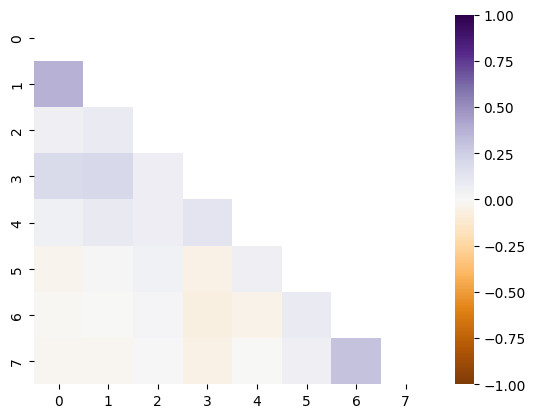

In [202]:
# Plots correlation as seaborn plot.

import seaborn as sb

tick_labels = list(range(len(vif_df)))
rows, cols = corr.shape
mask = np.invert(np.tril(np.ones((rows, cols), dtype=bool), k=-1))
dataplot = sb.heatmap(
    corr,
    cmap="PuOr",
    xticklabels=tick_labels,
    yticklabels=tick_labels,
    mask=mask,
    vmin=-1,
    vmax=1,
)

[[0, "ControlPullRequestHasComments"], [1, "ControlPullRequestHasCommentByExternalUser"], [2, "ControlHasHashTagInDescription"], [3, "ln(1 + ControlPullRequestLifeTimeInMinutes)"], [4, "ln(1 + ControlNumberOfCommitsInPullRequest)"], [5, "ln(1 + IntraProjectSubmitterPullRequestCommentCount)"], [6, "ln(1 + WeightedEcosystemSecondOrderInDegreeCentrality)"], [7, "ln(1 + EcosystemIntegratorToSubmitterLinkIntensity)"]]


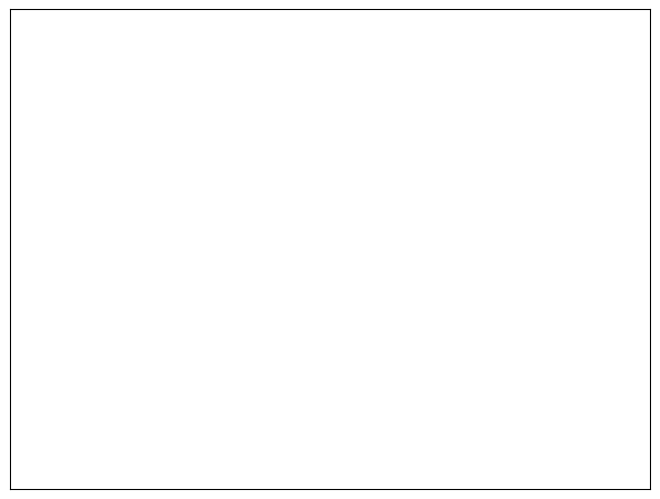

In [ ]:
# Plots correlations as a graph.

import networkx as nx
import matplotlib.pyplot as plt

fields = list(logit_df.columns)
enumerated_list = list(enumerate(fields))
ids = []
edge_colors = []
for source, target, coof in correlating_fields:
    source_idx = fields.index(source)
    target_idx = fields.index(target)
    ids.append((source_idx, target_idx))
    edge_colors.append("red" if coof < 0 else "green")

# Create an empty graph
graph = nx.Graph()

# Add edges to the graph from the list of tuples
graph.add_edges_from(ids)

pos = nx.spring_layout(graph, k=0.4)
nx.draw(graph, pos, with_labels=True, edge_color=edge_colors)

if len(correlating_fields) > 0:
    print("When there are no correlating fields, the figure is supposed to be empty.")

output_path = f"{figure_base_path}/correlating_fields.png"
safe_save_fig(output_path)

print(json.dumps(enumerated_list))

## Outliers

Using cook's distance.


In [204]:
import statsmodels.api as sm
import scipy

X_constant = sm.add_constant(logit_df)

# Use GLM method for logreg here so that we can retrieve the influence measures
logit_results = sm.GLM(
    df[pr_merged_key], X_constant, family=sm.families.Binomial()
).fit()

# Get influence measures
influence = logit_results.get_influence()

# Obtain summary df of influence measures
summ_df = influence.summary_frame()

# Filter summary df to Cook's distance values only
diagnosis_df = summ_df[["cooks_d"]]

# Set Cook's distance threshold
cook_threshold = 4 / len(logit_df)

# Append absolute standardized residual values
diagnosis_df["std_resid"] = scipy.stats.zscore(logit_results.resid_pearson)
diagnosis_df["std_resid"] = diagnosis_df["std_resid"].apply(lambda x: np.abs(x))

# Find observations which are BOTH outlier (std dev > 3) and highly influential
extreme = diagnosis_df[
    (diagnosis_df["cooks_d"] > cook_threshold) & (diagnosis_df["std_resid"] > 3)
]


# Show top 5 highly influential outlier observations
extreme.sort_values("cooks_d", ascending=False).head(10)

/tmp/ipykernel_8843/1249922847.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diagnosis_df['std_resid'] = scipy.stats.zscore(logit_results.resid_pearson)
/tmp/ipykernel_8843/1249922847.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diagnosis_df['std_resid'] = diagnosis_df['std_resid'].apply(


,cooks_d,std_resid
344388,0.000915,8.098497
1093429,0.000749,5.614993
473525,0.000735,4.156916
660076,0.000707,3.966149
465902,0.000699,4.495247
663989,0.000674,6.470389
1012486,0.000662,8.535546
1009754,0.000614,4.806405
659514,0.000610,4.410762
1011869,0.000609,7.214701


9.371566199572188e-06
Found outliers: 465 / 426832 (0.109%)


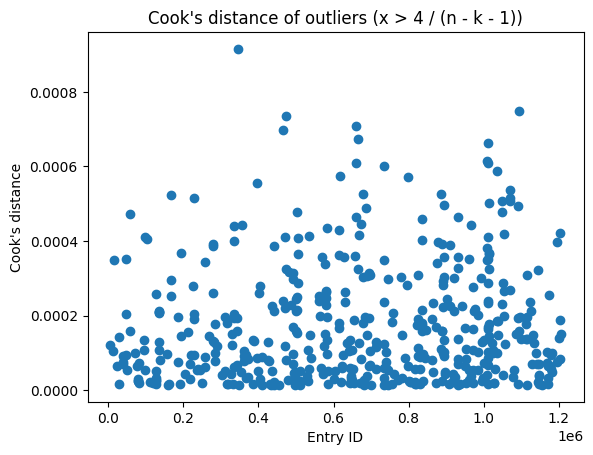

In [205]:
cook_threshold = 4 / (len(logit_df) - len(logit_df.columns) - 1)
print(cook_threshold)
print(
    f"Found outliers: {len(extreme)} / {len(logit_df)} ({100 * len(extreme)/len(logit_df):.03f}%)"
)

plt.title("Cook's distance of outliers (x > 4 / (n - k - 1))")
plt.scatter(extreme.index, extreme["cooks_d"])
plt.xlabel("Entry ID")
plt.ylabel("Cook's distance")

output_path = f"{figure_base_path}/cooks_outliers.png"
safe_save_fig(output_path)

Removes outliers

In [206]:
logit_df = logit_df.drop(extreme.index)
tested_dependents = dependent.drop(extreme.index)

print(f"{len(logit_df)=}")

len(logit_df)=426367


# Model Creation

Creates a simple mixed effect logistic regression model.

In [207]:
from statsmodels.regression.mixed_linear_model import MixedLM

# Selects relevant project names.
pn_key = "Project Name"
tested_projects = df[pn_key].copy()
tested_projects = tested_projects[logit_df.index]

# Creates model.
mixed_model = MixedLM(
    tested_dependents,
    logit_df,
    tested_projects,
).fit()

mixed_model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Mixed Linear Model Regression Results
==================================================================================================
Model:                       MixedLM            Dependent Variable:            PullRequestIsMerged
No. Observations:            426367             Method:                        REML               
No. Groups:                  20050              Scale:                         0.1834             
Min. group size:             1                  Log-Likelihood:                -280842.7146       
Max. group size:             505                Converged:                     Yes                
Mean group size:             21.3                                                                 
--------------------------------------------------------------------------------------------------
                                                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------
ControlPullRequestHasComments                          -0.042    0.002 -22.537 0.000 -0.046 -0.038
ControlPullRequestHasCommentByExternalUser             -0.068    0.002 -38.271 0.000 -0.071 -0.064
ControlHasHashTagInDescription                          0.050    0.002  31.815 0.000  0.047  0.053
ln(1 + ControlPullRequestLifeTimeInMinutes)            -0.199    0.003 -58.395 0.000 -0.206 -0.193
ln(1 + ControlNumberOfCommitsInPullRequest)            -0.147    0.012 -12.721 0.000 -0.170 -0.125
ln(1 + IntraProjectSubmitterPullRequestCommentCount)    0.422    0.020  21.000 0.000  0.383  0.461
ln(1 + WeightedEcosystemSecondOrderInDegreeCentrality)  0.358    0.009  38.590 0.000  0.340  0.376
ln(1 + EcosystemIntegratorToSubmitterLinkIntensity)     0.523    0.014  37.152 0.000  0.496  0.551
Group Var                                               0.750    0.021                            
==================================================================================================

"""

###

In [209]:
import os

# outputs results to a csv.

summ = mixed_model.summary()

fields = summ.tables[1]
output = pd.DataFrame()
for field in fields.columns:
    output[f"Dependency Model: {field}"] = fields[field]

dir_name = f"{base_path}/coefs/{file_name}/{experiment_name}"
output_path = f"{dir_name}/coefs.csv"
if not os.path.exists(dir_name):
    os.makedirs(dir_name)

output.to_csv(output_path)

In [210]:
import datetime

print(datetime.datetime.now())

2024-02-19 12:54:36.494446
